In [ ]:
%cd /content/drive/MyDrive/CSC14116-LTSSUD

/content/drive/MyDrive/CSC14116-LTSSUD


In [ ]:
# Load model
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D
import numpy as np
import cv2
from keras import backend as K

## Cài đặt tuần tự

### Thiết kế


Activation("relu") \
Formula: $f(x) = max(0,x)$
*   List item

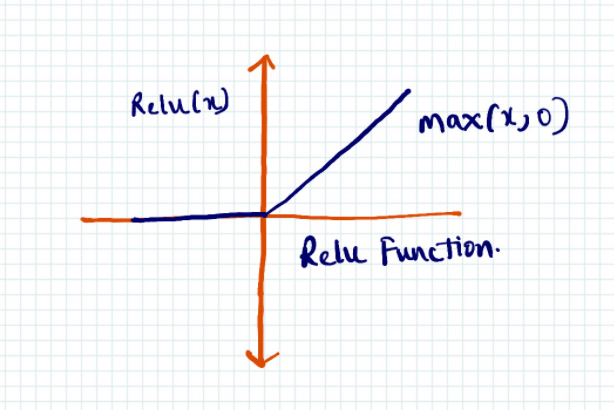

MaxPool2D \

*   List item

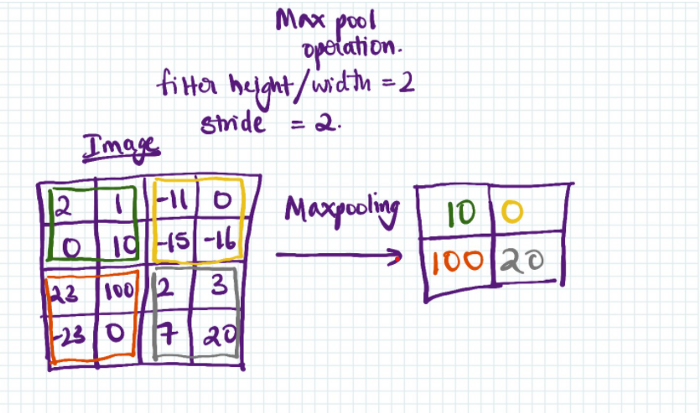

Nguồn ảnh: https://medium.com/@PAdhokshaja/simple-cnn-using-numpy-part-iii-relu-max-pooling-softmax-c03a3377eaf2

### Cài đặt

#### Sử dụng thư viện kiểm tra

In [ ]:
pretrain_model = load_model('unet.h5')

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    outputs = MaxPool2D((2, 2))(x)

    """ Output """
    return Model(inputs, outputs, name="U-Net")

In [ ]:
# Read input and build model
x = read_image("/content/drive/MyDrive/CSC14116-LTSSUD/zoom5.jpg")
x = np.expand_dims(x, axis=0)

input_shape = (256, 256, 3)
model = build_unet(input_shape)

In [ ]:
# Load pretrain weights 
for i in range(1,3):
  exits_w = pretrain_model.layers[i].weights
  model.layers[i].set_weights(pretrain_model.layers[i].weights)

In [ ]:
%%capture
model(x)

In [ ]:
# Create var for checking 
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function(inp, out) for out in outputs]    # evaluation functions

# Layers weights
layer_outs = [func(x) for func in functors]

#### Activation("relu")

In [ ]:
import time
from numba import jit

In [ ]:
@jit(cache=True)
def relu(x):
  # np.maximum(0,x)
  return (x>0)*x

In [ ]:
# Check  answer
before_ac = np.array(layer_outs[2])
after_ac = np.array(layer_outs[3])

start = time.time()
np.abs(relu(before_ac)-after_ac).sum()
end = time.time()
print(f'Processing time for activation: {end - start} s')

Processing time for activation: 0.727679967880249 s


#### MaxPool2D

In [ ]:
@jit(cache=True)
def maxpool(x, pool_size = 2,stride = 2):
  output_width = int((x.shape[1]-pool_size)/stride)+1
  pooled = np.zeros((1,output_width,output_width,x.shape[3]))

  # Iterate over all pools
  for k in np.arange(x.shape[3]):
    for i in np.arange(x.shape[1], step=stride):
      for j in np.arange(x.shape[1], step=stride):
          mat = x[:,i:i+pool_size, j:j+pool_size, k]

          # Ensure that the shape of the matrix is 2x2 (pool size)
          if (mat.shape[1],mat.shape[2]) == (pool_size, pool_size):
              pooled[:,int(i/2),int(j/2),k]=np.max(mat)
          else:
            print("error")
            break
      
  return pooled

In [ ]:
# Check  answer
before_maxpool = np.array(layer_outs[3])
after_maxpool = np.array(layer_outs[4])

# input dim (1,256,256,3)
start = time.time()
np.abs(maxpool(before_maxpool)-after_maxpool).sum()
end = time.time()
print(f'Processing time for activation: {end - start} s')

Processing time for activation: 1.970045566558838 s


In [ ]:
### Đánh giá